In [ ]:
# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display a sample of the entries
display(data.sample(8, random_state=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
24874,41,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
1910,36,Local-gov,Some-college,10.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
19812,26,Private,Bachelors,13.0,Never-married,Sales,Not-in-family,White,Female,0.0,0.0,40.0,United-States,<=50K
20453,47,Private,Assoc-voc,11.0,Divorced,Sales,Unmarried,Black,Female,0.0,0.0,25.0,United-States,<=50K
26897,26,Private,9th,5.0,Never-married,Other-service,Own-child,White,Female,0.0,0.0,38.0,El-Salvador,<=50K
15923,30,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,45.0,United-States,<=50K
28418,24,Private,Bachelors,13.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K
21950,41,Private,Assoc-voc,11.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [2]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = n_records - n_greater_50k

# Percentage of individuals whose income is more than $50,000
greater_percent = float(n_greater_50k) / n_records * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

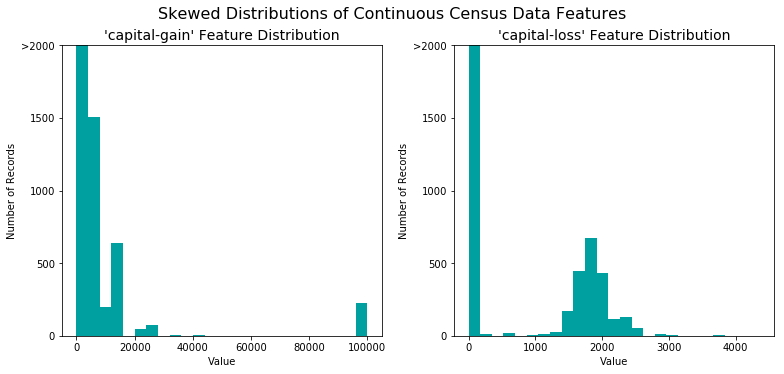

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

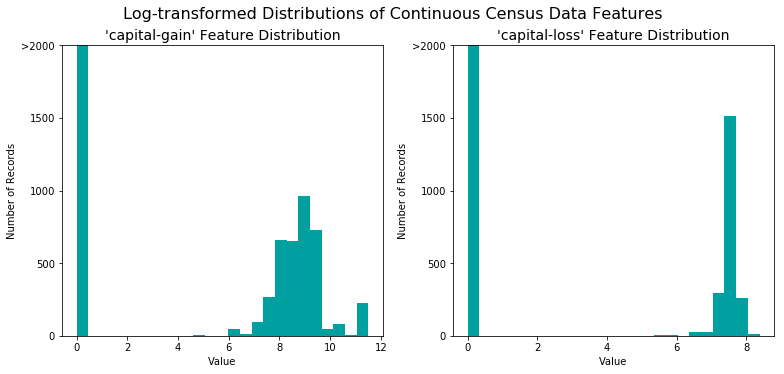

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as examplified below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of records with scaling applied
display(features_raw.sample(8, random_state=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
24874,0.328767,Private,Some-college,0.600000,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,0.397959,United-States
1910,0.260274,Local-gov,Some-college,0.600000,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,0.397959,United-States
19812,0.123288,Private,Bachelors,0.800000,Never-married,Sales,Not-in-family,White,Female,0.0,0.0,0.397959,United-States
20453,0.410959,Private,Assoc-voc,0.666667,Divorced,Sales,Unmarried,Black,Female,0.0,0.0,0.244898,United-States
26897,0.123288,Private,9th,0.266667,Never-married,Other-service,Own-child,White,Female,0.0,0.0,0.377551,El-Salvador
15923,0.178082,Private,Masters,0.866667,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,0.448980,United-States
28418,0.095890,Private,Bachelors,0.800000,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,0.448980,United-States
21950,0.328767,Private,Assoc-voc,0.666667,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,0.377551,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# Encode the 'income_raw' data to numerical values
income = pd.get_dummies(income_raw, drop_first=True)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

print 'Vector "income" is encoded correctly if all places where income is less than or equal $50K is encoded as 0.'
print 'Is "income"encoded correctly? ...'+('yes' if all(income_raw[income['>50K'] == 0] == '<=50K') else 'no')

103 total features after one-hot encoding.
Vector "income" is encoded correctly if all places where income is less than or equal $50K is encoded as 0.
Is "income"encoded correctly? ...yes


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income['>50K'], test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# Calculate accuracy
accuracy = float(n_greater_50k) / n_records

# Calculate F-score using the formula above for beta = 0.5
recall = float(n_greater_50k) / (n_greater_50k + 0) 
precision = float(n_greater_50k) / (n_greater_50k + n_at_most_50k) # in this case = accuracy
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: ** The first supervised learning model that is appropriate for this problem is _Support Vector Machines_, or SVMs. My research turned up uses in finance and [biology](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/1472-6947-10-16), but understandably for the former they are not revealing the details. The latter had Yu et al finding that they were able to detect diagnosed and undiagnosed diabetes 83.5% of the time from non-laboratory markers and undiagnosed or pre-diabetes 73.2% of the time with 2 additional markers. Interestingly, another [application of SVMs](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btm026) from the related field of bioinformatics showed >= 85% specificity, sensititivy, and accuracy (most were in the high 90s) of classifying microRNA from a certain loop of RNA called a "hairpin". Moving on, SVMs are effective in "high dimensional spaces", and is versatile due to the choice in kernel functions. Drawbacks include the ability to label only two classes and the difficulty in intrepreting trained model coefficients. I believe a SVM is a good candidate because it handles high numbers of features well, since after one-hot encoding we have 103 features. 

The second model I will choose is _K-Nearest Neighbors_ or kNN. In industry, kNN has been employed in [predicting stock prices and desired features](https://lra.le.ac.uk/handle/2381/37772) (the link is a doctoral thesis but dollars to donuts this is being used in financial firms). The strengths of this model is that it is non-parametric and doesn't assume an underlying model, so it can fit complex patterns. A weakness is that it has to store all the data points, which at > 40K might be a lot for us. I believe that this model is a good candidate because intuitively, people with similar occupations and backgrounds should make around the same amount of money, so measureing "likeness" makes sense here. Furthermore, following the [scikit-learn algorithm cheat sheet](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) led me to believe that this would be an appropriate choice; i.e. we are predicting a category, we have < 100K samples, and we assume that the linear support vector classifier isn't working. 

Finally, I will choose the ensemble method of _Random Forest_ as it is, according to its Berkley professor inventor, ["unexcelled in accuracy among current algorithms"](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#features). While this could be chalked up to fluff by the creator, the opinion is shared by [Google machine learning practioners](http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/) and others in [industry](http://www.sciencedirect.com/science/article/pii/S0924271616000265). The latter case is a review of Random Forests usage in remote sensing, where it has been employed to "identify the most relevant multisource remote sensing and geographic data". It only makes sense to include this highly accurate model and test its performance. Some pros of this method is that it runs efficiently on large datasets, high feature dimensions, and even outputs a measure of importance of each feature, aka it performs some implicit feature selection (more advantages [here](https://medium.com/rants-on-machine-learning/the-unreasonable-effectiveness-of-random-forests-f33c3ce28883). A drawback is memory consumption: large forests might be hard to store and slow to evaluate. I believe this model is approrpiate because it seems to be effective on most ML tasks, and that we have high feature dimensions that might benefit from some feature tuning, so to speak.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set and then the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples and test set
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples and test set
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LinearSVC trained on 362 samples.
LinearSVC trained on 3618 samples.
LinearSVC trained on 36177 samples.
KNeighborsClassifier trained on 362 samples.
KNeighborsClassifier trained on 3618 samples.
KNeighborsClassifier trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.


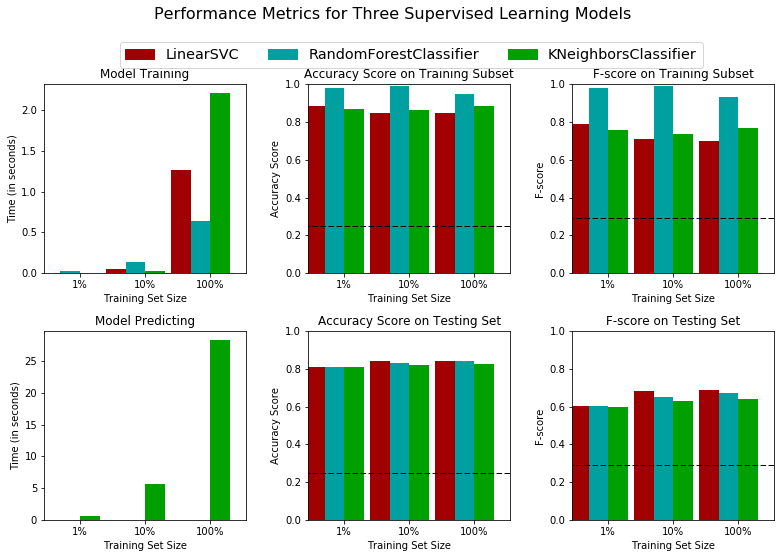

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the three models
clf_A = LinearSVC(random_state=5)
clf_B = KNeighborsClassifier()
clf_C = RandomForestClassifier(random_state=5)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
from math import ceil
train_samples = len(X_train)
samples_1 = int(ceil(train_samples*.01))
samples_10 = int(ceil(train_samples*.1))
samples_100 = train_samples

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

In [11]:
print 'LinearSVC'
display(results['LinearSVC'][2])
print 'RandomForestClassifier'
display(results['RandomForestClassifier'][2])

LinearSVC


{'acc_test': 0.84267551133222773,
 'acc_train': 0.84666666666666668,
 'f_test': 0.68556430446194216,
 'f_train': 0.70075757575757569,
 'pred_time': 0.008568048477172852,
 'train_time': 1.2651379108428955}

RandomForestClassifier


{'acc_test': 0.83869541182974017,
 'acc_train': 0.94999999999999996,
 'f_test': 0.67358547051192497,
 'f_train': 0.93354430379746856,
 'pred_time': 0.047057151794433594,
 'train_time': 0.6457860469818115}

**Answer: **  
Hello CharityML representative,

I believe that of the three models tested, I believe that the results show the "linear support vector machine classifier", aka `LinearSVC` above, is the most appropriate for the task. While on the surface all three algorithms performed roughly the same, we can see clear differences by examining the results closer. For example, we can immediately eliminate the `KNearestClassifier` as taking taking far too long to predict, not to mention coming in last for accuracy and f-score. Once we scale up the predictions to number in the millions, the code will take too long to predict the person in question's income. The other model, `RandomForest`, has similar scores and prediciton/training times as our chosen model. However, looking closer at the numbers, we can see that `LinearSVC` is slightly higher in accuracy and a full percentage point higher in its f-score (a measure of precision and recall, with more emphasis on precision in our case). Since we are interested in maximizing the efficency of our calls and therefore maximizing percentage of correctly predicted people who make >$50K--the precision of our calls--we should select the highest f-score which reflects this. 

Thus by process of elimination we selected `LinearSVC` from the three examined.

An SVM classifier is suitable to a problem of this nature because it works well with the high number of features our data set has. While it might take slightly longer than a random forest to train (about 20% longer, but still fast relative to kNN), prediction times with the SVM are 10 times faster. Thus, as you scale the training and testing set to the millions, predicting a person's income should be relatively quick. 

Sincerely,  
Charlie

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** A support vector machine starts with the simple task of how to best separate the data into its two classes. In our case, we have 103 dimensions in which we want to draw a "hyperplane", or high-dimensional plane, that best divides the features of people between those who make >$50K and those who don't. An analog of this situation is, if you had a clear cube filled with red dots and blue dots, you would try to to cut the cube straight through into two pieces that would best maximize the amount of red on side and the amount of blue on the other. Since "best" is a bit subjective, in the case of the SVMs we mean we maximize the distance between the two differet classes, while still getting as many correct classifications on each side. 

Sometimes, the data distrubtion doesn't lend itself to be "linearly separable"; in other words, you couldn't cut straight through the cube to split the dots.For example, all the red dots might be near the surface of the cube, while the blue might be on the interior. Fortunately, through the "kernel trick" of the SVM implementation, you can transform the data to a higher dimensional space, where the distances between dots are equivalent, and make a straight cut through the now separated data. This straight cut through the higher dimensional cube might look wobbly in the original, but it turns out to be the right separation. A picture is helpful in building intuition: 

<img src="https://upload.wikimedia.org/wikipedia/commons/1/1b/Kernel_Machine.png" width="250" alt="kernel trick of an SVM" title="kernel trick of an SVM">

On the left, a line (also known as a 2D plane) cannot be draw that completely and accurately separates the classes. However, on the right, after kernel function has been applied, the data is transformed into something which can be divided by a straight line. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LinearSVC(random_state=5)

# Create the parameters list you wish to tune
parameters = {'dual': [True, False], 
              'class_weight': ['balanced', None], 
              'C': np.logspace(-3, 10, 14)
             }

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=beta)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scorer)

# Fit the grid search object to the training data and find the optimal parameters
print '...starting estimator search...'
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "\nUnoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

...starting estimator search...

Unoptimized model
------
Accuracy score on testing data: 0.8427
F-score on testing data: 0.6856

Optimized Model
------
Final accuracy score on the testing data: 0.8430
Final F-score on the testing data: 0.6874


In [13]:
print best_clf

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=5, tol=0.0001,
     verbose=0)


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |              0.2478 |            0.8427 |          0.8430 |
| F-score        |              0.2917 |            0.6856 |          0.6874 |


**Answer: ** From above, the optimized model has an accuracy of 84.30% and an F-score of 0.6874. These results are marginally better than the unoptimized model, with an increase of only 0.03% points in accuracy and .0018 points in F-score. Compared to the naive predictor benchmark, the optimized model will correctly predict potential donors 3.4x more frequently. This would be valuable to Charity ML. Furthermore, the F-score is 2.3x higher than the benchmark. Since this is our measure that is more sensitive to the measure of potentially successful calls (aka people actually making >$50K of those we call), this is quite a significant gain. 

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

In [14]:
print ' | '.join(data.columns[:-1])

age | workclass | education_level | education-num | marital-status | occupation | relationship | race | sex | capital-gain | capital-loss | hours-per-week | native-country


**Answer:** If I had to guess, I would put `education-num` highest, since I am a millennial who bought into the idea that getting a college degree will lead to a better job (`education_level` is also important, but would be correlated with `education-num` and so only one will be picked). Next I would put `occupation`, because your job usually determines your income. Next, `hours-per-week`, since usually full-time jobs make more than part-time, depending on your job (which is why I would rank it below `occupation`). Next, I would select `capital-gain` as an important feature, since I can't select a composite feature of `(capital-gain - capital-loss)`. I would assume those with more income would play the stock market or invest more, and those with capital gains would have higher income. Finally, I select `age` as the last important feature. I reason that the older you are, the longer you would be working, and hopefully the more you would make in your career. However, this does not always the case of course, and older people are more apt to retire. But at least there should be some relationship.

To clarify, my guess at the five most important features are: 
1. `education-num`
2. `occupation`
3. `hours-per-week`
4. `capital-gain`
5. `age`

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

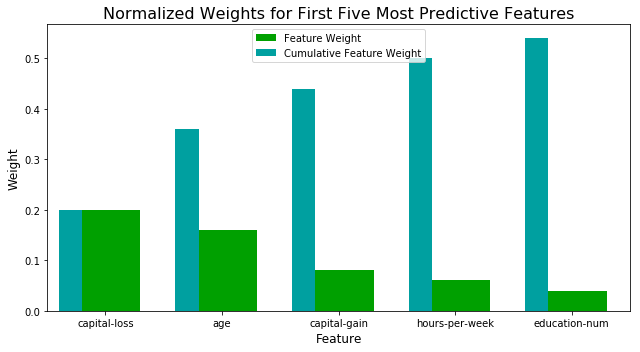

In [15]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

#  Train the supervised model on the training set 
model = AdaBoostClassifier(random_state=5).fit(X_train, y_train)

#  Extract the feature importances
importances = model.feature_importances_

#  Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** Four of the five features I discussed appeared in the most relevant features, though none in the right order. I am surprised `occupation` isn't an important feature, since it seems to fix your income within a range. However, `capital-loss` and `capital-gain` being important confirms my intuition that the ability to have investment activity and also the result of that activity plays a heavy role in predicting income. Further, `age` being the second most important predictor shows that it has an even larger role in predicting income than I anticipated. My ego also appreciates `education-num` making an appearance since I ranked it first.   

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [16]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8430
F-score on testing data: 0.6874

Final Model trained on reduced data
------
Accuracy on testing data: 0.8029
F-score on testing data: 0.5740


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

In [17]:
print 'Optimized SVM Model'
result1 = train_predict(best_clf, samples_100, X_train, y_train, X_test, y_test)
print '> Training time:', round(result1['train_time'], 4)
print ''
print 'Feature-Reduced Optimized SVM Model'
result2 = train_predict(clf, samples_100, X_train, y_train, X_test, y_test)
print '> Training time:', round(result2['train_time'], 4)
# print ''
# print 'Benchmarks: accuracy = {}, f-score = {}'.format(accuracy, fscore)

Optimized SVM Model
LinearSVC trained on 36177 samples.
> Training time: 0.1137

Feature-Reduced Optimized SVM Model
LinearSVC trained on 36177 samples.
> Training time: 0.1087


**Answer:** The final model's F-score and accuracy suffers using the top five features, but not overmuch. There is about a 5% reduction in the accuracy (loss of 4 percentage points to 80.29%) and a 16% reduction in F-score (loss of about 0.11 to 0.5740) from the model that uses all the features, while only gaining an 8% speedup of training time. While these are well above the minimum benchmarks (accuracy=0.2478, fscore=0.2917), I don't like sacrificing the accuracy and precision to save 5 minutes, supposing our original training time was an hour. Therefore, in this case, with my current choice of model, I would not use the reduced data as my training set. 

However, in general, if training time was a factor, and the reduced data gave similiar results based on the chosen metric(s), then of course I would consider using reduced data. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.